In [ ]:
import requests
from bs4 import BeautifulSoup

from datetime import datetime, timedelta

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import time

In [ ]:
finished_matches = pd.DataFrame(columns=[
    'date', 'winning_team', 'losing_team', 'home_team', 'away_team', 'score', 'venue'])
unfinished_matches = pd.DataFrame(columns=[
    'date', 'home_team', 'away_team', 'venue'])

In [ ]:
for page_number in range(1, 12):
    link = f'https://www.svleague.jp/en/sv_men/match/list?calender=&league_id%5B%5D=20&pg={page_number}'

    response = requests.get(link)
    soup = BeautifulSoup(response.text, 'html.parser')

    match_area = soup.find('div', class_='matchArea3')

    if match_area:
        schedule_blocks = match_area.find_all('div', class_='matchScheduleBlock')

        for block in schedule_blocks:
            body = block.find('div', class_='matchScheduleBlockBody')

            date_body = body.find('div', class_='matchScheduleDate')
            year = date_body.find('span', class_='year').text
            date = date_body.find('span', class_='date').text.replace('.', '/')
            time_t = date_body.find('span', class_='time').text
            date_and_time = datetime.strptime(f'{year} {date} {time_t}', '%Y %m/%d %H:%M')

            game_info = body.find('div', class_='gameBox')
            result_box = game_info.find('div', class_='resultBox')
            venue = game_info.find('div', class_='venue').text.strip()

            teamA = result_box.find('div', class_='teamA').text.replace('"', '').strip()
            teamB = result_box.find('div', class_='teamB').text.replace('"', '').strip()
            teamA, teamAhome = teamA.split('\n')
            teamAhome = True if teamAhome == 'HOME' else False
            teamB, teamBhome = teamB.split('\n')
            teamBhome = True if teamBhome == 'HOME' else False
            home_team = teamA if teamAhome else teamB
            away_team = teamA if teamBhome else teamB

            score = result_box.find('div', class_='point').text.strip()

            if score == 'VS':
                unfinished_matches.loc[len(unfinished_matches)] = [date_and_time.strftime('%Y-%m-%dT%H:%M'), home_team, away_team, venue]

            else:
                scoreA, scoreB = map(int, score.split('-'))

                teamAwinner = True if scoreA > scoreB else False
                teamBwinner = True if scoreB > scoreA else False
                score = f'{max(scoreA, scoreB)}-{min(scoreA, scoreB)}'

                finished_matches.loc[len(finished_matches)] = [date_and_time.strftime('%Y-%m-%dT%H:%M'),
                                                              teamA if teamAwinner else teamB,
                                                              teamA if teamBwinner else teamB,
                                                              home_team, away_team, score, venue]

                # # placeholer print statement
                # print(date_and_time.strftime('%m/%d/%Y'),
                #       f"{teamA if teamAwinner else teamB}\t\twon against {teamA if teamBwinner else teamB}\t\tat {venue}")

    time.sleep(0.5)

In [ ]:
finished_matches

,date,winning_team,losing_team,home_team,away_team,score,venue
0,2024-10-19T12:00,VEERTIEN,NARA,NARA,VEERTIEN,3-1,田原本町中央体育館
1,2024-10-19T13:00,FKAGOSHIMA,HYOGO Delfino,FKAGOSHIMA,HYOGO Delfino,3-0,南さつま市加世田運動公園体育館
2,2024-10-19T14:02,HOKKAIDO YS,GaRons,GaRons,HOKKAIDO YS,3-0,須坂市市民体育館
3,2024-10-20T12:00,VEERTIEN,NARA,NARA,VEERTIEN,3-0,田原本町中央体育館
4,2024-10-20T12:00,FKAGOSHIMA,HYOGO Delfino,FKAGOSHIMA,HYOGO Delfino,3-1,南さつま市加世田運動公園体育館
...,...,...,...,...,...,...,...
103,2025-01-05T12:00,Kinki,HYOGO Delfino,Kinki,HYOGO Delfino,3-0,新居浜市市民体育館
104,2025-01-05T13:00,HOKKAIDO YS,R Tochigi,R Tochigi,HOKKAIDO YS,3-0,FUKAI SQUARE GARDEN 足利
105,2025-01-05T13:00,SAITAMA,FUJITSU,FUJITSU,SAITAMA,3-0,川崎市多摩スポーツセンター
106,2025-01-05T13:00,VEERTIEN,AISIN,VEERTIEN,AISIN,3-0,三重交通G スポーツの杜 鈴鹿 体育館


In [ ]:
finished_matches[finished_matches['winning_team'] == 'Chiba']

,date,winning_team,losing_team,home_team,away_team,score,venue
34,2024-11-10T13:00,Chiba,TOKYOVERDY,TOKYOVERDY,Chiba,3-0,多摩市立総合体育館
99,2025-01-04T14:00,Chiba,GaRons,GaRons,Chiba,3-2,須坂市市民体育館


In [ ]:
finished_matches[finished_matches['losing_team'] == 'Chiba']

,date,winning_team,losing_team,home_team,away_team,score,venue
25,2024-11-09T14:00,TOKYOVERDY,Chiba,TOKYOVERDY,Chiba,3-1,多摩市立総合体育館
38,2024-11-16T13:00,GaRons,Chiba,Chiba,GaRons,3-1,YohaSアリーナ～本能に、感動を。～
44,2024-11-17T12:00,GaRons,Chiba,Chiba,GaRons,3-0,YohaSアリーナ～本能に、感動を。～
63,2024-11-30T14:00,R Tochigi,Chiba,R Tochigi,Chiba,3-0,DAIKYOアリーナ佐野
65,2024-12-01T13:00,R Tochigi,Chiba,R Tochigi,Chiba,3-1,DAIKYOアリーナ佐野
70,2024-12-07T13:00,FUJITSU,Chiba,Chiba,FUJITSU,3-0,YohaSアリーナ～本能に、感動を。～
77,2024-12-08T12:00,FUJITSU,Chiba,Chiba,FUJITSU,3-0,YohaSアリーナ～本能に、感動を。～
87,2024-12-28T13:00,Sun GAIA,Chiba,Chiba,Sun GAIA,3-0,城西国際大学（スポーツ文化センター）
90,2024-12-29T12:00,Sun GAIA,Chiba,Chiba,Sun GAIA,3-0,城西国際大学（スポーツ文化センター）
101,2025-01-05T12:00,GaRons,Chiba,GaRons,Chiba,3-1,須坂市市民体育館


In [ ]:
unfinished_matches

,date,home_team,away_team,venue
0,2025-01-11T12:00,NARA,Kinki,FSS35スポーツアリーナ
1,2025-01-11T13:00,KUBOTA,Kinden,大阪市立東淀川体育館
2,2025-01-11T13:00,FKAGOSHIMA,Daido,フラゴラアリーナ日置
3,2025-01-11T14:00,AISIN,FUKUOKA WS,碧南市臨海体育館
4,2025-01-12T12:00,NARA,Kinki,FSS35スポーツアリーナ
...,...,...,...,...
139,2025-03-23T12:00,FKAGOSHIMA,AISIN,Fアリーナいちき串木野
140,2025-03-23T13:00,R Tochigi,Sun GAIA,FUKAI SQUARE GARDEN 足利
141,2025-03-23T13:00,FUJITSU,Chiba,川崎市とどろきアリーナ（サブアリーナ）
142,2025-03-23T13:00,Daido,FUKUOKA WS,弥富市総合社会教育センター


In [ ]:
unfinished_matches['venue'].nunique()

54

## Graph based approach for match-up predicting

In [ ]:
from collections import defaultdict

In [ ]:
# ensure the scores are inputted from the alphabetically lower team to the larger team
all_scores = defaultdict(lambda: [])

In [ ]:
for i, row in finished_matches.iterrows():
    winning_team = row['winning_team']
    losing_team = row['losing_team']

    winning_score = 3
    losing_score = int(row['score'].split('-')[-1])

    # if winning_team > losing_team:
    #     matchup_score = (losing_score - winning_score) / 3 # max number of matches is 3
    # else:
    #     matchup_score = (winning_score - losing_score) / 3
    # print(winning_team, losing_team, matchup_score)

    matchup_score = (3 - losing_score) / 3 # max number of matches is 3

    if winning_team > losing_team:
        matchup_score *= -1 # score are stored from alphabetically lesser to greater team

    all_scores[frozenset([winning_team, losing_team])].append(matchup_score)

In [ ]:
import networkx as nx

In [ ]:
G = nx.DiGraph()

for teams, scores in all_scores.items():
    teamA, teamB = map(lambda x: x, list(set(teams)))
    G.add_edge(min(teamA, teamB), max(teamA, teamB), weight=np.mean(scores))
    G.add_edge(max(teamA, teamB), min(teamA, teamB), weight=-np.mean(scores))

In [ ]:
def predict_score_method1(G, source, target, k=3): # k is the max paths to consider
    paths = list(nx.all_simple_paths(G, source=source, target=target, cutoff=k)) # default is dijkstra

    scores = []
    for path in paths:
        path_score = sum(G[path[i]][path[i+1]]['weight'] for i in range(len(path) - 1))

        decay_factor = 1 / ((len(path) - 1) ** 2)  # or np.exp(-len(path))
        scores.append(path_score * decay_factor)

        # dividing by (len(path) - 1) once gives the mean
        # dividing by (len(path) - 1) twice gives the weight

        if len(path) > 3:
            factored_score = (1 / (len(path) - 1) ** function_order) * (path_score ** function_order)
        else:
            factored_score = path_score / (len(path) - 1)

        scores.append(factored_score)

    return np.mean(scores)

function_order = 5 # cubic

def predict_score_method2(G, source, target, k=3): # k is the max paths to consider
    paths = list(nx.all_simple_paths(G, source=source, target=target, cutoff=k)) # default is dijkstra

    scores = []

    for path in paths:
        path_score = sum(G[path[i]][path[i+1]]['weight'] for i in range(len(path) - 1))

        if len(path) > 2:
            factored_score = (1 / (len(path) - 1) ** function_order) * (path_score ** function_order)
        else: # path is at least two
            factored_score = path_score / (len(path) - 1)

        scores.append(factored_score)

    return np.mean(scores)

In [ ]:
# No weights on the length of the path
def predict_score_method3(G, source, target, k=3): # k is the max paths to consider
    paths = list(nx.all_simple_paths(G, source=source, target=target, cutoff=k)) # default is dijkstra

    scores = []
    for path in paths:
        path_score = sum(G[path[i]][path[i+1]]['weight'] for i in range(len(path) - 1))
        scores.append(path_score / (len(path) - 1))

    return np.mean(scores)

# Uses a simple weighted mean (of the additive inverses of the values)
def predict_score_method4(G, source, target, k=3): # k is the max paths to consider
    paths = list(nx.all_simple_paths(G, source=source, target=target, cutoff=k)) # default is dijkstra

    scores = defaultdict(list)
    for path in paths:
        path_score = sum(G[path[i]][path[i+1]]['weight'] for i in range(len(path) - 1))
        scores[len(path) - 1].append(path_score / (len(path) - 1))

    path_length_keys = list(scores.keys())

    final_score = 0
    for path_length, score_list in scores.items():
        factor = (max(path_length_keys) + min(path_length_keys) - path_length) / sum(path_length_keys)
        final_score += factor * np.mean(score_list)
        # scores[path_length] = np.mean(score_list)

    return final_score

In [ ]:
predict_score_method4(G, source='Chiba', target='HOKKAIDO YS', k=3)

-0.662962962962963

In [ ]:
unfinished_matches_copy = unfinished_matches.copy()
unfinished_matches_copy['predicted_score_method1'] = unfinished_matches_copy.apply(
    lambda row: predict_score_method1(G, source=row['home_team'], target=row['away_team'], k=3), axis=1)
unfinished_matches_copy['predicted_score_method2'] = unfinished_matches_copy.apply(
    lambda row: predict_score_method2(G, source=row['home_team'], target=row['away_team'], k=3), axis=1)
unfinished_matches_copy['predicted_score_method3'] = unfinished_matches_copy.apply(
    lambda row: predict_score_method3(G, source=row['home_team'], target=row['away_team'], k=3), axis=1)
unfinished_matches_copy['predicted_score_method4'] = unfinished_matches_copy.apply(
    lambda row: predict_score_method4(G, source=row['home_team'], target=row['away_team'], k=3), axis=1)

In [ ]:
unfinished_matches_copy

,date,home_team,away_team,venue,predicted_score_method1,predicted_score_method2,predicted_score_method3,predicted_score_method4
0,2025-01-11T12:00,NARA,Kinki,FSS35スポーツアリーナ,0.022962,0.000343,-0.007716,0.045370
1,2025-01-11T13:00,KUBOTA,Kinden,大阪市立東淀川体育館,0.071447,0.002118,0.151389,0.199603
2,2025-01-11T13:00,FKAGOSHIMA,Daido,フラゴラアリーナ日置,0.241603,0.168961,0.324074,0.592593
3,2025-01-11T14:00,AISIN,FUKUOKA WS,碧南市臨海体育館,0.125516,0.030949,0.363248,0.402222
4,2025-01-12T12:00,NARA,Kinki,FSS35スポーツアリーナ,0.022962,0.000343,-0.007716,0.045370
...,...,...,...,...,...,...,...,...
139,2025-03-23T12:00,FKAGOSHIMA,AISIN,Fアリーナいちき串木野,0.007300,0.000291,0.042929,0.020988
140,2025-03-23T13:00,R Tochigi,Sun GAIA,FUKAI SQUARE GARDEN 足利,0.069517,0.064247,0.096154,0.423611
141,2025-03-23T13:00,FUJITSU,Chiba,川崎市とどろきアリーナ（サブアリーナ）,0.149932,0.084636,0.275641,0.668056
142,2025-03-23T13:00,Daido,FUKUOKA WS,弥富市総合社会教育センター,0.101267,0.076005,0.166667,0.379630


In [ ]:
def normalize(x):
    if x.max() > abs(x.min()):
        return x / x.max()
    else:
        return x / abs(x.min())

In [ ]:
columns_to_normalize = ['predicted_score_method1', 'predicted_score_method2', 'predicted_score_method3', 'predicted_score_method4']
unfinished_matches_copy[columns_to_normalize] = unfinished_matches_copy[columns_to_normalize].apply(normalize)

# for column in columns_to_normalize:
#     unfinished_matches_copy[column] = (unfinished_matches_copy[column] - unfinished_matches_copy[column].min()) / (unfinished_matches_copy[column].max() - unfinished_matches_copy[column].min())

In [ ]:
unfinished_matches_copy['name'] = unfinished_matches_copy['home_team'] + ' vs ' + unfinished_matches_copy['away_team']
unfinished_matches_copy['name'] = unfinished_matches_copy['name'] + ' (' + unfinished_matches_copy['date'].apply(lambda x: x[5:10]) + ')'

unfinished_matches_copy.sort_values(by='predicted_score_method4', ascending=True, key=abs).head(10)

,date,home_team,away_team,venue,predicted_score_method1,predicted_score_method2,predicted_score_method3,predicted_score_method4,name
139,2025-03-23T12:00,FKAGOSHIMA,AISIN,Fアリーナいちき串木野,0.025330,0.001032,0.068878,0.025018,FKAGOSHIMA vs AISIN (03-23)
133,2025-03-22T13:00,FKAGOSHIMA,AISIN,Fアリーナいちき串木野,0.025330,0.001032,0.068878,0.025018,FKAGOSHIMA vs AISIN (03-22)
29,2025-01-26T12:00,HYOGO Delfino,FUKUOKA WS,明石中央体育会館,-0.024773,-0.001422,-0.066852,-0.026490,HYOGO Delfino vs FUKUOKA WS (01-26)
27,2025-01-25T14:00,HYOGO Delfino,FUKUOKA WS,明石中央体育会館,-0.024773,-0.001422,-0.066852,-0.026490,HYOGO Delfino vs FUKUOKA WS (01-25)
9,2025-01-18T13:00,Chiba,TOKYOVERDY,YohaSアリーナ～本能に、感動を。～,-0.052035,0.042106,-0.152561,0.034216,Chiba vs TOKYOVERDY (01-18)
16,2025-01-19T12:00,Chiba,TOKYOVERDY,YohaSアリーナ～本能に、感動を。～,-0.052035,0.042106,-0.152561,0.034216,Chiba vs TOKYOVERDY (01-19)
17,2025-01-19T12:00,GaRons,FUJITSU,須坂市市民体育館,-0.038678,-0.000650,-0.062674,-0.042219,GaRons vs FUJITSU (01-19)
13,2025-01-18T14:00,GaRons,FUJITSU,須坂市市民体育館,-0.038678,-0.000650,-0.062674,-0.042219,GaRons vs FUJITSU (01-18)
97,2025-03-02T13:00,FUJITSU,GaRons,宮前スポーツセンター,0.038678,0.000650,0.062674,0.042219,FUJITSU vs GaRons (03-02)
90,2025-03-01T13:00,FUJITSU,GaRons,宮前スポーツセンター,0.038678,0.000650,0.062674,0.042219,FUJITSU vs GaRons (03-01)


In [ ]:
import matplotlib.pyplot as plt

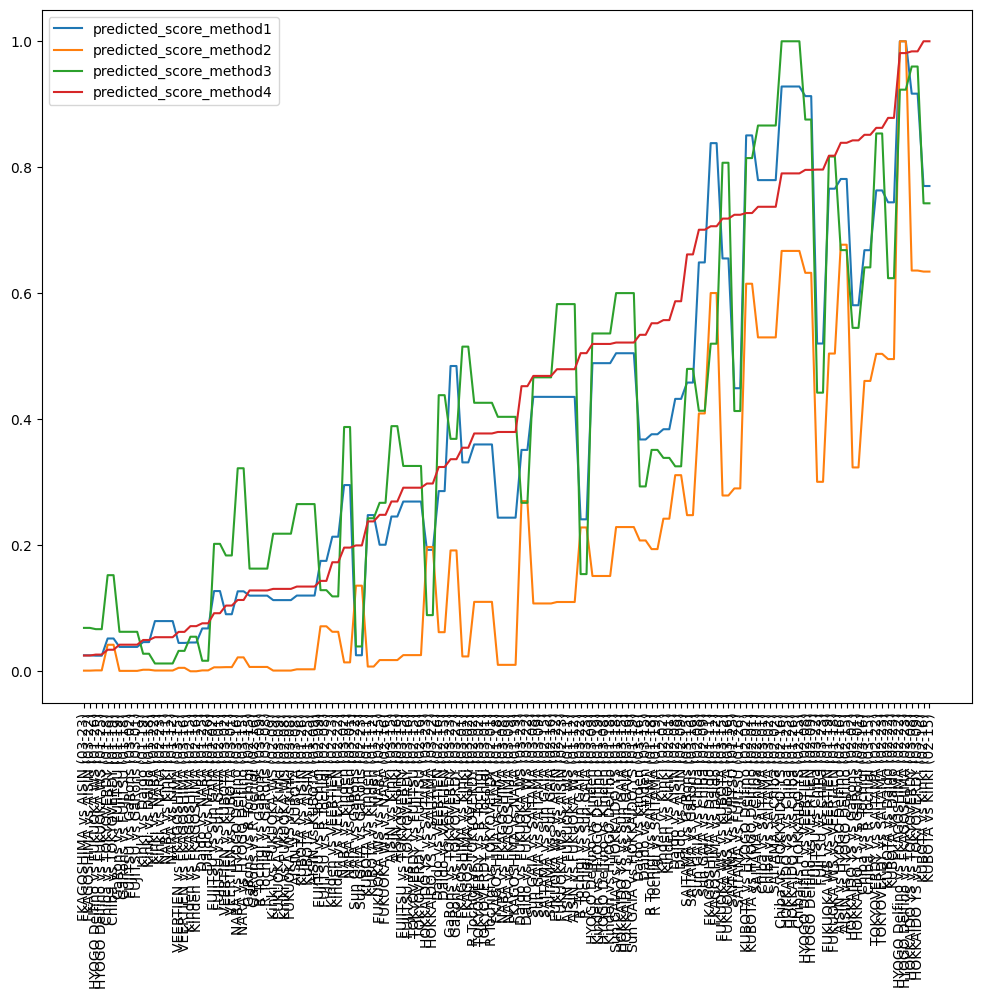

In [ ]:
plt.figure(figsize=(12, 9))

sorted_unfinished_matches = unfinished_matches_copy.sort_values(by='predicted_score_method4', ascending=True, key=abs)

plt.plot(sorted_unfinished_matches['name'], abs(sorted_unfinished_matches['predicted_score_method1']), label='predicted_score_method1')
plt.plot(sorted_unfinished_matches['name'], abs(sorted_unfinished_matches['predicted_score_method2']), label='predicted_score_method2')
plt.plot(sorted_unfinished_matches['name'], abs(sorted_unfinished_matches['predicted_score_method3']), label='predicted_score_method3')
plt.plot(sorted_unfinished_matches['name'], abs(sorted_unfinished_matches['predicted_score_method4']), label='predicted_score_method4')

plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
sorted_unfinished_matches

,date,home_team,away_team,venue,predicted_score_method1,predicted_score_method2,predicted_score_method3,predicted_score_method4,name
139,2025-03-23T12:00,FKAGOSHIMA,AISIN,Fアリーナいちき串木野,0.025330,0.001032,0.068878,0.025018,FKAGOSHIMA vs AISIN (03-23)
133,2025-03-22T13:00,FKAGOSHIMA,AISIN,Fアリーナいちき串木野,0.025330,0.001032,0.068878,0.025018,FKAGOSHIMA vs AISIN (03-22)
29,2025-01-26T12:00,HYOGO Delfino,FUKUOKA WS,明石中央体育会館,-0.024773,-0.001422,-0.066852,-0.026490,HYOGO Delfino vs FUKUOKA WS (01-26)
27,2025-01-25T14:00,HYOGO Delfino,FUKUOKA WS,明石中央体育会館,-0.024773,-0.001422,-0.066852,-0.026490,HYOGO Delfino vs FUKUOKA WS (01-25)
9,2025-01-18T13:00,Chiba,TOKYOVERDY,YohaSアリーナ～本能に、感動を。～,-0.052035,0.042106,-0.152561,0.034216,Chiba vs TOKYOVERDY (01-18)
...,...,...,...,...,...,...,...,...,...
81,2025-02-23T12:00,HYOGO Delfino,FKAGOSHIMA,南あわじ市文化体育館,-1.000000,-1.000000,-0.923199,-0.981236,HYOGO Delfino vs FKAGOSHIMA (02-23)
104,2025-03-08T15:00,HOKKAIDO YS,TOKYOVERDY,Kitagas Arena Sapporo,0.916859,0.636083,0.959931,0.983996,HOKKAIDO YS vs TOKYOVERDY (03-08)
112,2025-03-09T15:00,HOKKAIDO YS,TOKYOVERDY,Kitagas Arena Sapporo,0.916859,0.636083,0.959931,0.983996,HOKKAIDO YS vs TOKYOVERDY (03-09)
70,2025-02-16T13:00,KUBOTA,Kinki,Baycom General Gymnasium,0.770266,0.634440,0.742804,1.000000,KUBOTA vs Kinki (02-16)


In [ ]:
sorted_unfinished_matches.to_csv('unfinished_matches_with_scores.csv', index=False)

### Leaderboard Generation

In [ ]:
# To evaluate the metrics, let's compare the predicted scores with the differences in leaderboard positions
set_leaderboard_wins = defaultdict(int)
set_leaderboard_losses = defaultdict(int)
match_leaderboard_wins = defaultdict(int)
match_leaderboard_losses = defaultdict(int)

leaderboard = pd.DataFrame(0, columns=['sets_won', 'sets_lost', 'matches_won', 'matches_lost'],
                           index=list(set(finished_matches['winning_team']).union(set(finished_matches['losing_team']))))

for _, row in finished_matches.iterrows():
    winning_team = row['winning_team']
    losing_team = row['losing_team']

    winning_sets = 3
    losing_sets = int(row['score'].split('-')[-1])

    leaderboard.loc[winning_team, 'sets_won'] += winning_sets
    leaderboard.loc[losing_team, 'sets_won'] += losing_sets
    leaderboard.loc[winning_team, 'sets_lost'] += losing_sets
    leaderboard.loc[losing_team, 'sets_lost'] += winning_sets

    leaderboard.loc[winning_team, 'matches_won'] += 1
    leaderboard.loc[losing_team, 'matches_lost'] += 1

In [ ]:
leaderboard['set_win_ratio'] = leaderboard['sets_won'] / (leaderboard['sets_won'] + leaderboard['sets_lost'])
leaderboard['match_win_ratio'] = leaderboard['matches_won'] / (leaderboard['matches_won'] + leaderboard['matches_lost'])

leaderboard['mean_win_ratio'] = (leaderboard['set_win_ratio'] + leaderboard['match_win_ratio']) / 2

In [ ]:
leaderboard.sort_values(by='mean_win_ratio', ascending=False)

,sets_won,sets_lost,matches_won,matches_lost,set_win_ratio,match_win_ratio,mean_win_ratio
HOKKAIDO YS,40,7,13,1,0.851064,0.928571,0.889818
VEERTIEN,46,13,15,1,0.779661,0.937500,0.858581
KUBOTA,34,9,11,1,0.790698,0.916667,0.853682
SAITAMA,27,9,8,2,0.750000,0.800000,0.775000
FKAGOSHIMA,32,11,9,3,0.744186,0.750000,0.747093
Kinden,29,16,9,3,0.644444,0.750000,0.697222
AISIN,26,18,7,5,0.590909,0.583333,0.587121
Sun GAIA,27,20,7,5,0.574468,0.583333,0.578901
GaRons,24,24,7,5,0.500000,0.583333,0.541667
R Tochigi,20,24,5,7,0.454545,0.416667,0.435606


In [ ]:
leaderboard.sort_values(by='mean_win_ratio', ascending=False).to_csv('leaderboard.csv', index=False)

### Checking predicted scores with difference in leaderboard `mean_win_ratio`s

In [ ]:
def return_unique_team_combos(df):
    seen_combinations = set()

    unique_indices = []

    for idx, row in df.iterrows():
        team_combination = frozenset([row['home_team'], row['away_team']])

        if team_combination not in seen_combinations:
            seen_combinations.add(team_combination)
            unique_indices.append(idx)

    unique_matches = df.loc[unique_indices]

    unique_matches.reset_index(drop=True, inplace=True)
    return unique_matches

unique_unfinished_matches = return_unique_team_combos(unfinished_matches_copy)

In [ ]:
metrics_dict = {f'predicted_score_method{i}': [] for i in range(1, 5)}

for _, row in unique_unfinished_matches.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    diff_mean_ratio = leaderboard.loc[home_team, 'mean_win_ratio'] - leaderboard.loc[away_team, 'mean_win_ratio']
    # Remove the abs to preserve data on which team is better

    for i in range(1, 5):
        predicted_score = row[f'predicted_score_method{i}']
        error = np.sqrt((predicted_score - diff_mean_ratio) ** 2)
        metrics_dict[f'predicted_score_method{i}'].append(error)

for i in range(1, 5):
    print(f'predicted_score_method{i}', np.mean(metrics_dict[f'predicted_score_method{i}']))

predicted_score_method1 0.17087377984239693
predicted_score_method2 0.1712393306613189
predicted_score_method3 0.14804663014038105
predicted_score_method4 0.2104886168943418


In [ ]:
mean_metrics = []

for _, row in unique_unfinished_matches.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    diff_mean_ratio = leaderboard.loc[home_team, 'mean_win_ratio'] - leaderboard.loc[away_team, 'mean_win_ratio']

    predicted_score = np.mean([row[f'predicted_score_method{i}'] for i in range(1, 5)])
    error = np.sqrt((predicted_score - diff_mean_ratio) ** 2)
    mean_metrics.append(error)

print('mean predicted score', np.mean(mean_metrics))

mean predicted score 0.15416309841021264


- wonder if you can use a script to get the price / time taken to travel to each of the venues and factor that in.
- then employ a minimization function that calculates the lowest **matches watched / yen** or a similar metric (see if you can plot on matplotlib).


The above approach shouldn't regard **match satisfaction** which is a function of how exciting the volleyball match is. This can be calculated using past match data, or the relative strengths of the teams by showing
- their lank on a leaderboard
- how evenly matched they were with other teams, as per match data
if A evenly matched B and B evenly matched C, then safe to say A is evenly matched with C even though they never played = now do this with ALL past matches and match combinations.
